In this notebook we are going to apply simple colorhistogram operations to detect cloudy images (and also images which are corrupted and probably have substantial black regions).

In [1]:
import rasterio

In [2]:
from glob import glob 

In [3]:
# read the filenames of all .tif images in the folder
filenames = glob("../../data/image_tiles_aws/*.tif")
len(filenames)

18534

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np

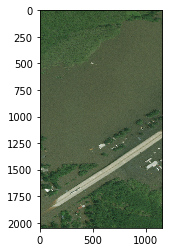

In [6]:
# look at an example image
with rasterio.open(filenames[10], 'r') as r:
    arr = r.read()
plt.imshow(np.rollaxis(arr,0,3))

To create a simple measure of how much "whiteness" is in the image, we can first calculate a grayscale image by averaging the channels of the RGB image. Then we can calculate the histogram of the greyscale image. The advantage of this approach is that it uses the distribution of the intensity values and it works for comparing images of different size.

In [7]:
# we set the density to true so all histogram values are normalized between 0 and 1
h, bins = np.histogram(arr[:,:,:].mean(axis=2), bins=100, density=True, range = [0,255])

<BarContainer object of 100 artists>

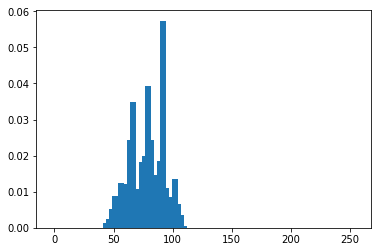

In [8]:
plt.bar(bins[:-1],h,5)

We will calculate the histogram for each image and we will store it in a dictionary.

In [ ]:
%%time
h_list = {}

for file in filenames:
    with rasterio.open(file, 'r') as r:
        arr = r.read()
        
    h, bins = np.histogram(arr[:,:,:].mean(axis=2), bins=100, density=True, range=[0,255])
    h_list[file] = h
    
    
    

In [10]:
len(filenames)

18534

In [11]:
import pandas as pd

In [12]:
# storing the histogram values to a csv file
pd.DataFrame(h_list).to_csv('hist.csv')

In [13]:
# read from the saved file
df = pd.read_csv('hist.csv', index_col = 0)

In [14]:
# read from memory
df = pd.DataFrame(h_list)

In [15]:
list(df.columns)[1]

'../../data/image_tiles_aws/20170829_1040010032211E00_2110020_jpeg_compressed_01_05.tif'

In [ ]:
!head -n 5 'hist.csv'

#### Dimensionality Reduction of Histograms
We believe that files which have clouds will have a distribution shifted to the right (or if only part of them is covered by clouds, maybe they have a bump to the left and a second mode where most common values are). The histograms can be thought as features of the images and we can perform dimensionality reduction of those feature to detect common patterns. One of the most popular methods for dimensionsionality reduction is PCA, but that method is better suitable for data which is Gaussian distributed. Histograms have some constraints which need to be satisfied: they are always positive with values between 0 and 1. Instead of PCA we can use Nonnegative Matrix Factorization (NMF), which is also provided through the `sklearn.decomposition` package.

In [17]:
import sklearn as sk

In [18]:

from sklearn.decomposition import NMF
pca = NMF(n_components=5)#, beta_loss='kullback-leibler')
pca.fit(df.T)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=5, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [19]:
X_transformed = pca.transform(df.T)

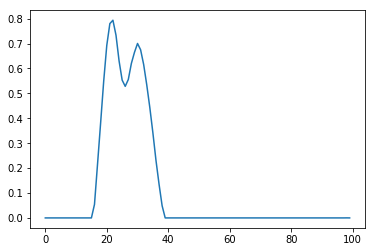

In [20]:
plt.plot(pca.components_[0,:])

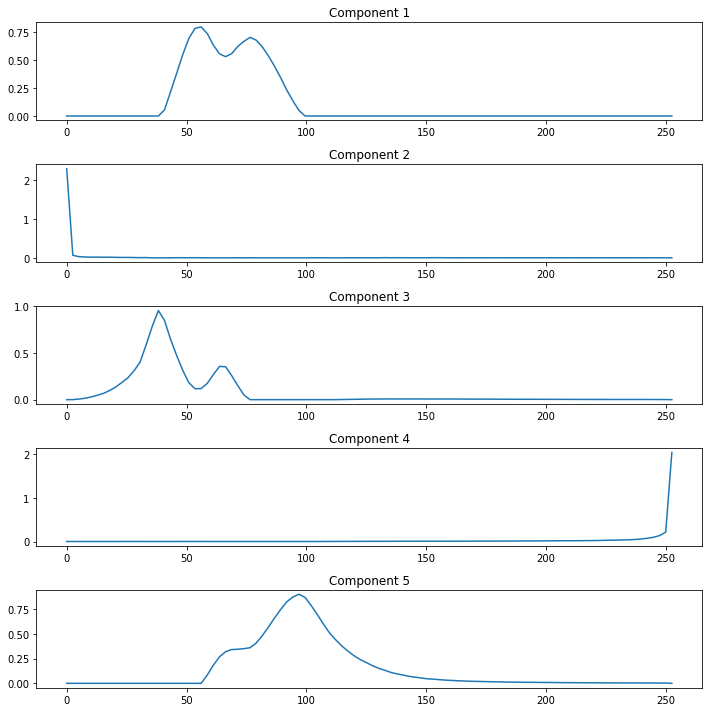

In [21]:
# Visualize the components
plt.figure(figsize = (10,10))
ax1 = plt.subplot(5, 1, 1)
for i in range(5):
    plt.subplot(5, 1, i+1, sharex=ax1)
    plt.plot(bins[:-1],pca.components_[i,:])
    plt.title('Component '+str(i+1))
plt.tight_layout()

We observe that first component has a peak around zero (balck images), and the 3rd component has a peak around 255 (mostly white images). Let's order the images by their coefficient corresponding to the 3rd component (here we have the advantage of all coefficients being positive: the larger the coefficient the larger the contribution).

In [22]:
# create an index of decreasing 4th component coefficient
idx = X_transformed[:,3].argsort()[::-1]
print(idx)

[ 1314  1313  1083 ... 10036 10035 18533]


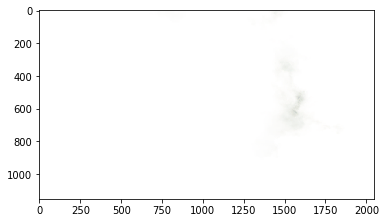

In [23]:
with rasterio.open(df.columns[idx[0]], 'r') as r:
    arr = r.read()
      
plt.imshow(np.rollaxis(arr,0,3))


In [24]:
# store the filenames order by their "whiteness"
with open('cloud_list.txt', 'w') as f:
    for item in df.columns[idx]:
        f.write("%s\n" % item)

In [25]:
!head -n 5 cloud_list.txt

../../data/image_tiles_aws/20170829_1040010032211E00_2112023_jpeg_compressed_10_03.tif
../../data/image_tiles_aws/20170829_1040010032211E00_2112023_jpeg_compressed_10_02.tif
../../data/image_tiles_aws/20170829_1040010032211E00_2112001_jpeg_compressed_10_07.tif
../../data/image_tiles_aws/20170829_1040010032211E00_2112020_jpeg_compressed_10_09.tif
../../data/image_tiles_aws/20170829_1040010032211E00_2112003_jpeg_compressed_05_06.tif


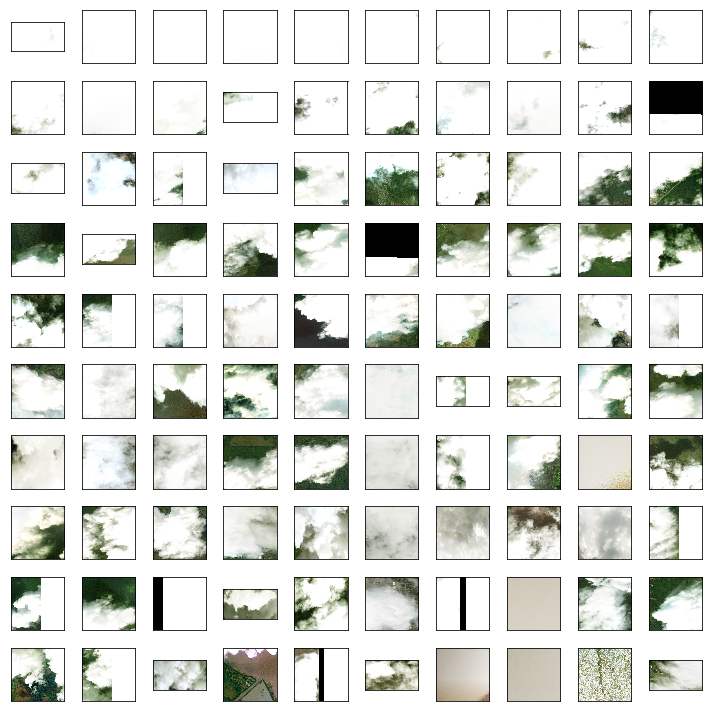

In [26]:
# Visualize the images in order of their "whiteness"
# order: left-to-right, row first
# skip - skips showing every skip'th image
# N - total number of images shown

import math
plt.figure(figsize = (10,10))
N = df.shape[1]
N = 1000
skip = 10
m = math.floor(math.sqrt(N/skip))
ax1 = plt.subplot(m, m, 1)
for i,j in enumerate(range(0,N,skip)):
    plt.subplot(m, m, i+1, sharex=ax1)
    with rasterio.open(df.columns[idx[j]], 'r') as r:
        arr = r.read()
    plt.imshow(np.rollaxis(arr,0,3))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

In [27]:
# create an index of decreasing 4th component coefficient
idx = X_transformed[:,1].argsort()[::-1]
print(idx)

[ 5400  5168  9301 ...  8665  8664 14697]


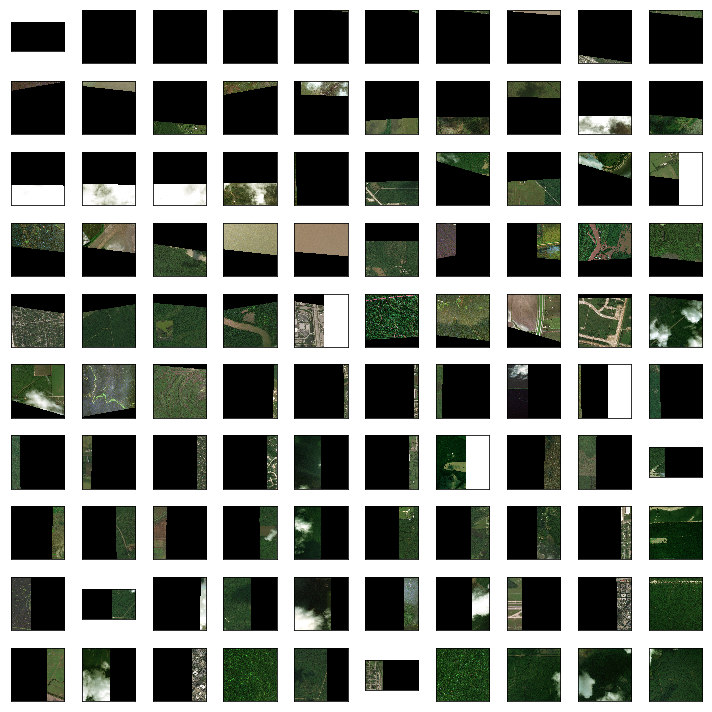

In [28]:
# Visualize the images in order of their "darkness"
# order: left-to-right, row first
# skip - skips showing every skip'th image
# N - total number of images shown

import math
plt.figure(figsize = (10,10))
N = df.shape[1]
N = 1000
skip = 10
m = math.floor(math.sqrt(N/skip))
ax1 = plt.subplot(m, m, 1)
for i,j in enumerate(range(0,N,skip)):
    plt.subplot(m, m, i+1, sharex=ax1)
    with rasterio.open(df.columns[idx[j]], 'r') as r:
        arr = r.read()
    plt.imshow(np.rollaxis(arr,0,3))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

In [29]:
# store the filenames order by their "whiteness"
with open('black_list.txt', 'w') as f:
    for item in df.columns[idx]:
        f.write("%s\n" % item)